# Comparing a USGSCSM and ISIS camera for Cassini ISS

In [1]:
import os 
import sys
os.environ["ISISROOT"] = "/usgs/pkgs/isis3"

import pysis
from pysis import isis

import knoten
from knoten import vis

import json

import ale
from ale import util
from ale.drivers.cassini_drivers import CassiniIssPds3LabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Fetch the test image

In [2]:
imageLink = 'https://pds-imaging.jpl.nasa.gov/data/cassini/cassini_orbiter/coiss_2071/data/1702247425_1702389962/N1702360370_1.IMG'
lblLink = os.path.splitext(imageLink)[0] + '.LBL'
!wget -N -P data/ {imageLink}
!wget -N -P data/ {lblLink}
fileName = 'data/' + os.path.split(lblLink)[1]

--2019-08-05 09:15:45--  https://pds-imaging.jpl.nasa.gov/data/cassini/cassini_orbiter/coiss_2071/data/1702247425_1702389962/N1702360370_1.IMG
Resolving pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data/N1702360370_1.IMG’ not modified on server. Omitting download.

--2019-08-05 09:15:46--  https://pds-imaging.jpl.nasa.gov/data/cassini/cassini_orbiter/coiss_2071/data/1702247425_1702389962/N1702360370_1.LBL
Resolving pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data/N1702360370_1.LBL’ not modified on server. Omitting download.



## Ingest the image, spiceinit, and create a usgscsm sensor model

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.ciss2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)
    
with CassiniIssPds3LabelNaifSpiceDriver(fileName) as driver:
    usgscsmString = to_usgscsm(driver)
    usgscsm_dict = json.loads(usgscsmString)
    csm_isd = os.path.splitext(fileName)[0] + '.json'
    json.dump(usgscsm_dict, open(csm_isd, 'w'))
camera = knoten.csm.create_csm(fileName)

In [4]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

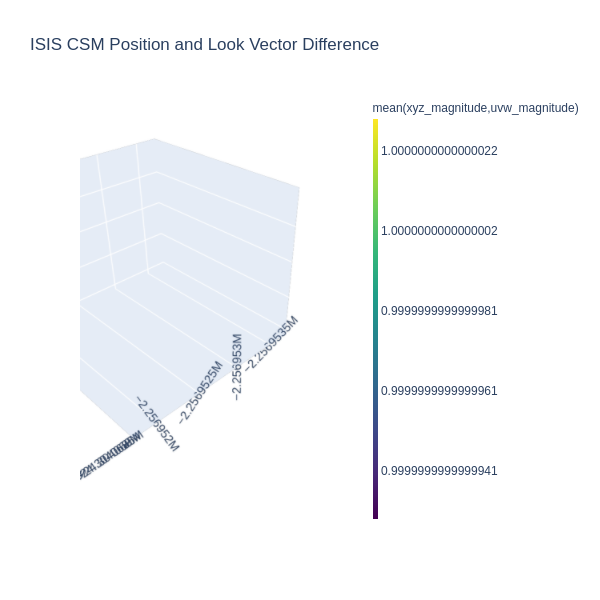

In [5]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

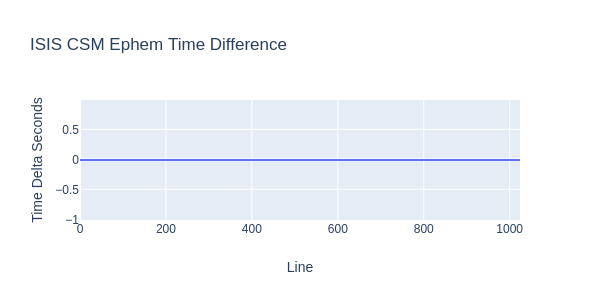

In [6]:
Image(csmisis_diff_ephem_plot_bytes)

In [7]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-34.417465,-2292.149379,-61.118243,-0.000267,0.000024,0.000155
std,0.000000,0.000000,0.000000,0.001527,0.000128,0.000875
min,-34.417465,-2292.149379,-61.118243,-0.002657,-0.000174,-0.001216
25%,-34.417465,-2292.149379,-61.118243,-0.001594,-0.000088,-0.000606
50%,-34.417465,-2292.149379,-61.118243,-0.000267,0.000022,0.000155
75%,-34.417465,-2292.149379,-61.118243,0.001060,0.000135,0.000916
max,-34.417465,-2292.149379,-61.118243,0.002124,0.000227,0.001527


In [8]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500)

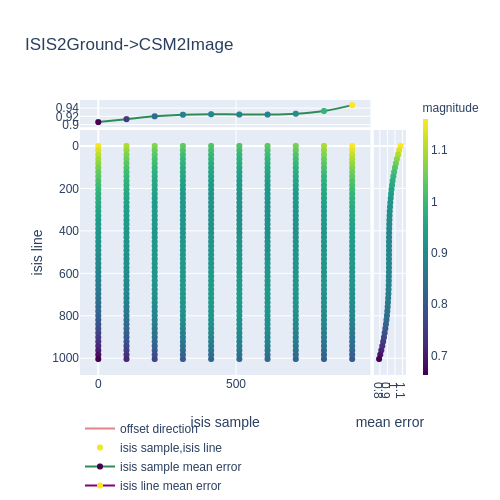

In [9]:
Image(isis2csm_plot.to_image())

In [10]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,0.897167,-0.211951
std,0.065100,0.067048
min,0.661505,-0.393951
25%,0.878192,-0.237212
50%,0.894516,-0.225303
75%,0.914609,-0.189390
max,1.153447,0.028093


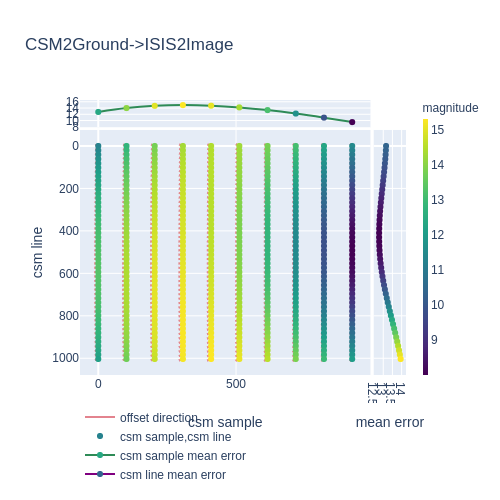

In [11]:
Image(csm2isis_plot.to_image())

In [12]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-0.120558,-12.260363
std,4.539192,2.184876
min,-9.139787,-15.018034
25%,-3.882381,-13.966030
50%,-0.233363,-12.825803
75%,3.552681,-11.055377
max,9.485359,-6.952459


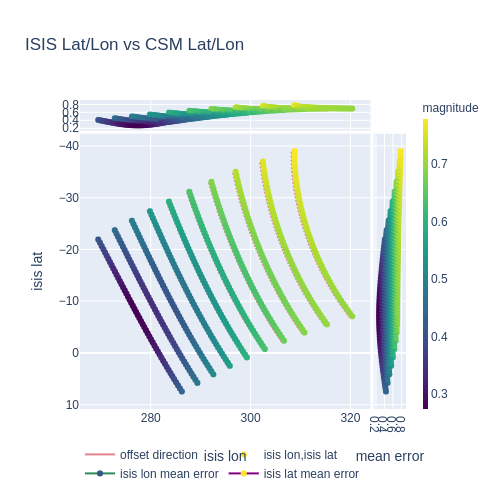

In [13]:
Image(isiscsm_plotlatlon.to_image())

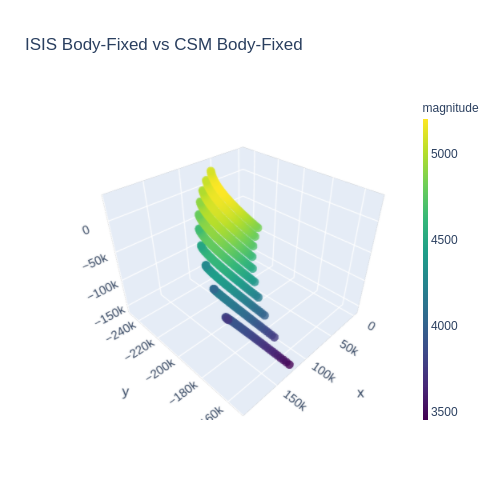

In [14]:
Image(isiscsm_plotbf.to_image())

In [15]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,0.002309,4605.826462,12.694107
std,0.005615,437.053533,24.780326
min,-0.023068,3438.747695,-79.337909
25%,-0.000049,4299.891296,-0.212391
50%,0.003272,4717.478888,15.349410
75%,0.005682,4979.340803,28.050994
max,0.015609,5184.429908,79.298727
